# **1. Cek resource**

In [ ]:
import torch

if torch.cuda.is_available():
  device = torch.device('cuda')

  print('there are %d GPU(s) available.' % torch.cuda.device_count())

  print('we will use the GPU: ', torch.cuda.get_device_name(0))
  USE_CUDA = True
else:
  USE_CUDA = False
  print("No GPU available, using the CPU instead")
  device = torch.device("cpu")

there are 1 GPU(s) available.
we will use the GPU:  Tesla T4


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install transformers

## Import library

In [ ]:
import pandas as pd
import time
import datetime
from tqdm import tqdm
import sklearn
from sklearn.metrics import confusion_matrix, roc_auc_score, matthews_corrcoef, ConfusionMatrixDisplay
# plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
def format_time(elapsed):
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

# Preparation

## Config

In [ ]:
RANDOM_SEED = 843734
max_seq = 128
epochs = 20
patience = 5
l_rate = 2e-5  # or 2e-5 5e-5 1e-6
batch_size = 16  # or 16

OUTPUT_DIM = 2 # 2 if Binary Classification
N_LAYERS = 1 # 2
BIDIRECTIONAL = True
DROPOUT = 0.2 # 0.2

main_path = "/content/gdrive/My Drive/TA/Ards/"

dataset_path = main_path + "datas/datasets_cleaned.csv"
graph_path =  main_path + "graph/"
report_path =  main_path + "report/"

bert_path = "indobenchmark/indobert-base-p2"
model_name = 'IBDmg_2e5_d2_16'
model_save_name = F"{model_name}.pth"
model_path = F"{main_path}saved/f_{model_save_name}"
best_model_path = F"{main_path}saved/b_{model_save_name}"
tokenizer_path = F"{main_path}tokenizer/{model_name}"
model_identifier = "f_"

# Load Data

In [ ]:
df=pd.read_csv(dataset_path, encoding='latin-1')
df.head()

,ï»¿usefulness,userName,score,at,content
0,1,IYAN JM,1,1/5/2023 7:22,tidak bisa upload foto ktp maupun stnk baik la...
1,1,Abdul Gani,1,1/5/2023 5:58,pembayaran ovo tidak bisa saya sudah isi ovo s...
2,1,oplet,1,1/5/2023 3:25,sudah daftar tapi tidak bisa masuk
3,0,Yudi Novianto,3,1/5/2023 3:13,kalo di saya aplikasi ini tidak terlalu bermas...
4,0,holdi saputra,1,1/5/2023 0:18,aplikasi tidak ada guna nya kebanyakan tidak b...


In [ ]:
df = df.rename(columns={'content': 'text', 'ï»¿usefulness': 'label'})
df.head()

,label,userName,score,at,text
0,1,IYAN JM,1,1/5/2023 7:22,tidak bisa upload foto ktp maupun stnk baik la...
1,1,Abdul Gani,1,1/5/2023 5:58,pembayaran ovo tidak bisa saya sudah isi ovo s...
2,1,oplet,1,1/5/2023 3:25,sudah daftar tapi tidak bisa masuk
3,0,Yudi Novianto,3,1/5/2023 3:13,kalo di saya aplikasi ini tidak terlalu bermas...
4,0,holdi saputra,1,1/5/2023 0:18,aplikasi tidak ada guna nya kebanyakan tidak b...


In [ ]:
text = df['text']
labels = df['label']

In [ ]:
labels.value_counts()

1    5205
0    5205
Name: label, dtype: int64

# Tokenizing

In [ ]:
import torch
import random
import numpy as np

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [ ]:
# Set random seed
set_seed(RANDOM_SEED)

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained(bert_path)

In [ ]:
from tabulate import tabulate

In [ ]:
max_length = df['text'].apply(lambda x: len(tokenizer.encode(x))).max()
max_indices = df[df['text'].apply(lambda x: len(tokenizer.encode(x))) == max_length].index.tolist()

In [ ]:
max_length

110

In [ ]:
max_indices = max_indices[0]

In [ ]:
len(tokenizer.encode(df['text'][max_indices]))

110

In [ ]:
df['text'][max_indices]

'waktu itu kendalanya setiap foto selalu maaf itu bukan struk bbk padahal jelas itu struk dari pertamina itu sudah agak benar eh sekarang tiap upload pilih dari foto ada batas scan nya dann parahnya adalah ketika baru foto kali itu bilang maaf batas scan anda habis maksudnya bagaimana coba terus juga ada keluar memory ram hp anda tidak cukup lah hape gue biasa biasa saja tuh kak kenapa kenapa dipakai fb twitter ig dan wa biasa saja kenapa repot benar pakai pertamina kalau memang nge php mengapai dibuat beginian kan mengapai meminta struk ke mbak mbaknya di pom'

In [ ]:
def tokenize_data(input_text, tokenizer):
  return tokenizer.encode_plus(input_text, add_special_tokens = True, max_length = max_seq,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )

In [ ]:
type(text)

pandas.core.series.Series

In [ ]:
input_ids = []
attention_masks = []

for sample in tqdm(text.tolist()):
  encoding_dict = tokenize_data(sample, tokenizer)
  input_ids.append(encoding_dict['input_ids'])
  attention_masks.append(encoding_dict['attention_mask'])

  0%|          | 0/10410 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 10410/10410 [00:20<00:00, 512.72it/s]


In [ ]:
labels

0        1
1        1
2        1
3        0
4        0
        ..
10405    0
10406    0
10407    0
10408    0
10409    0
Name: label, Length: 10410, dtype: int64

In [ ]:
input_ids = torch.cat(input_ids, dim = 0)
attention_masks = torch.cat(attention_masks, dim = 0)

In [ ]:
labels

0        1
1        1
2        1
3        0
4        0
        ..
10405    0
10406    0
10407    0
10408    0
10409    0
Name: label, Length: 10410, dtype: int64

### Observe some random tokenized data

In [ ]:
def print_rand_sentence_encoding():
  '''Displays tokens, token IDs and attention mask of a random text sample'''
  index = random.randint(0, len(text) - 1)
  textx = "kenapa memasukan nota untuk menjadi kupon sangat sulit meski dengan cara manual sulit untuk terverifikasi"
  tokens = tokenizer.tokenize(tokenizer.decode(input_ids[index]))
  tokenny = tokenizer.tokenize(textx)
  sample_token_ids = [i.numpy() for i in input_ids[index]]
  attention = [i.numpy() for i in attention_masks[index]]

  table = np.array([tokens, sample_token_ids, attention]).T
  print(tabulate(table,
                 headers = ['Tokens', 'Token IDs', 'Attention Mask'],
                 tablefmt = 'fancy_grid'))
  print("Tokens       : ", tokenny)
  print("Token IDs: ", input_ids[index])
  print("Attention Mask: ", attention_masks[index])

print_rand_sentence_encoding()

╒══════════╤═════════════╤══════════════════╕
│ Tokens   │   Token IDs │   Attention Mask │
╞══════════╪═════════════╪══════════════════╡
│ [CLS]    │           2 │                1 │
├──────────┼─────────────┼──────────────────┤
│ rakyat   │        1829 │                1 │
├──────────┼─────────────┼──────────────────┤
│ sudah    │         259 │                1 │
├──────────┼─────────────┼──────────────────┤
│ susah    │        3684 │                1 │
├──────────┼─────────────┼──────────────────┤
│ tambah   │        3837 │                1 │
├──────────┼─────────────┼──────────────────┤
│ di       │          26 │                1 │
├──────────┼─────────────┼──────────────────┤
│ bikin    │        2999 │                1 │
├──────────┼─────────────┼──────────────────┤
│ susah    │        3684 │                1 │
├──────────┼─────────────┼──────────────────┤
│ [SEP]    │           3 │                1 │
├──────────┼─────────────┼──────────────────┤
│ [PAD]    │           0 │        

# Split data

## Split with train_test_split

In [ ]:
from sklearn.model_selection import train_test_split


# Split data into 90% train and 10% test
train_input_1, test_input, train_labels_1, test_labels = train_test_split(input_ids,
                                                                      labels,
                                                                      random_state=RANDOM_SEED,
                                                                      test_size=0.1,
                                                                      stratify=labels)
train_mask, test_mask, _, _ = train_test_split(attention_masks,
                                               labels,
                                               random_state=RANDOM_SEED,
                                               test_size=0.1,
                                               stratify=labels)

# Split remaining 90% train data into 70% train and 20% validation
train_input, validation_input, train_labels, validation_labels = train_test_split(train_input_1,
                                                                                  train_labels_1,
                                                                                  random_state=RANDOM_SEED,
                                                                                  test_size=0.222,
                                                                                  stratify=train_labels_1)
train_mask, validation_mask, _, _ = train_test_split(train_mask,
                                                     train_labels_1,
                                                     random_state=RANDOM_SEED,
                                                     test_size=0.222,
                                                     stratify=train_labels_1)


In [ ]:
original_train_labels = train_labels
original_train_labels

8373    0
4845    1
2888    0
509     1
9000    1
       ..
5874    1
7875    0
4684    1
7352    0
6804    0
Name: label, Length: 7289, dtype: int64

In [ ]:
original_test_labels = test_labels
original_test_labels

6508     0
3239     0
1542     1
8122     0
6454     0
        ..
6857     0
8466     0
10330    0
7587     0
2155     1
Name: label, Length: 1041, dtype: int64

In [ ]:
original_val_labels = validation_labels
original_val_labels

9019    1
3931    1
3399    0
9154    1
2934    0
       ..
8483    0
1171    1
9940    0
5435    0
2613    0
Name: label, Length: 2080, dtype: int64

In [ ]:
train_labels = train_labels.values.tolist()
validation_labels = validation_labels.values.tolist()
test_labels = test_labels.values.tolist()

In [ ]:
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
test_labels = torch.tensor(test_labels)

In [ ]:
import numpy as np
print("== Train ==")
print("Input: ", train_input.shape)
print("Label: ", train_labels.shape)
print("Mask: ", np.array(train_mask).shape)

print("\n== Validation ==")
print("Input: ", validation_input.shape)
print("Label: ", validation_labels.shape)
print("Mask: ", np.array(validation_mask).shape)

print("\n== Test ==")
print("Input: ", test_input.shape)
print("Label: ", test_labels.shape)
print("Mask: ", np.array(test_mask).shape)

== Train ==
Input:  torch.Size([7289, 128])
Label:  torch.Size([7289])
Mask:  (7289, 128)

== Validation ==
Input:  torch.Size([2080, 128])
Label:  torch.Size([2080])
Mask:  (2080, 128)

== Test ==
Input:  torch.Size([1041, 128])
Label:  torch.Size([1041])
Mask:  (1041, 128)


In [ ]:
unique_train_labels, counts_train_labels = torch.unique(train_labels, return_counts=True)
unique_validation_labels, counts_validation_labels = torch.unique(validation_labels, return_counts=True)
unique_test_labels, counts_test_labels = torch.unique(test_labels, return_counts=True)

print("train_labels", unique_train_labels)  # tensor([0, 1])
print(counts_train_labels)
print("validation_labels", unique_validation_labels)  # tensor([0, 1])
print(counts_validation_labels)
print("train_labels", unique_test_labels)  # tensor([0, 1])
print(counts_test_labels)

train_labels tensor([0, 1])
tensor([3645, 3644])
validation_labels tensor([0, 1])
tensor([1040, 1040])
train_labels tensor([0, 1])
tensor([520, 521])


## Ubah ke dataloader

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

train_data = TensorDataset(train_input, train_mask, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_input, validation_mask, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

test_data = TensorDataset(test_input, test_mask, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

# Prepare Model

## Model Class

In [ ]:
import torch.nn as nn
from transformers import PreTrainedModel, BertConfig

In [ ]:
class IndoBERTBiLSTM(PreTrainedModel):
    config_class = BertConfig
    def __init__(self, bert_config, bert_pretrained_path, hidden_dim, num_classes, n_layers, bidirectional, dropout):
        super().__init__(bert_config)
        self.output_dim = num_classes
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.bidirectional = bidirectional

        self.bert = bert_pretrained_path
        self.lstm = nn.LSTM(input_size=self.bert.config.hidden_size,
                            hidden_size=hidden_dim,
                            num_layers=n_layers,
                            bidirectional=bidirectional,
                            batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.output_layer = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask):

        hidden = self.init_hidden(input_ids.shape[0])
        # print("hidden : ", type(hidden))
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = output.last_hidden_state

        lstm_output, (hidden_last, cn_last) = self.lstm(sequence_output, hidden)

        hidden_last_L=hidden_last[-2]
        hidden_last_R=hidden_last[-1]
        hidden_last_out=torch.cat([hidden_last_L,hidden_last_R],dim=-1) #[16, 1536]

        # apply dropout
        out = self.dropout(hidden_last_out)

        # output layer
        logits = self.output_layer(out)

        return logits

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data

        number = 1
        if self.bidirectional:
            number = 2

        if (USE_CUDA):
            hidden = (weight.new(self.n_layers*number, batch_size, self.hidden_dim).zero_().float().cuda(),
                      weight.new(self.n_layers*number, batch_size, self.hidden_dim).zero_().float().cuda()
                     )
        else:
            hidden = (weight.new(self.n_layers*number, batch_size, self.hidden_dim).zero_().float(),
                      weight.new(self.n_layers*number, batch_size, self.hidden_dim).zero_().float()
                     )

        return hidden

In [ ]:
from transformers import BertModel, AdamW, BertConfig, AutoModel

bert = BertModel.from_pretrained(bert_path)
bert_config = BertConfig()

In [ ]:
HIDDEN_DIM = 768

## new instance

In [ ]:
model = IndoBERTBiLSTM(
              bert_config,
              bert,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT)

model.cuda()

IndoBERTBiLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

## Loss and Optimizer

In [ ]:
# loss function
criterion = nn.BCEWithLogitsLoss()

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=l_rate)
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 2e-05
    maximize: False
    weight_decay: 0
)


# Train

## Checkpoint

In [ ]:
class SaveBestModel:
    """
    Class to save the best model while training. If the current epoch's
    metrics is better than the previous, then save the
    model state.
    """
    def __init__(
        self, mode='min'
    ):
        self.mode= mode
        if mode == 'max':
          self.best_metrics = 0.0
        elif mode == 'min':
          self.best_metrics = float('inf')

    def __call__(
        self, metrics,
        epoch, model, optimizer, criterion
    ):
        if self.mode == 'max':
          if metrics > self.best_metrics:
            print(f"\nValidation Accuracy improved from {self.best_metrics} to {metrics}")
            self.best_metrics = metrics
            print(f"Saving best model for epoch: {epoch}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict()
                }, best_model_path)
            return True
          else :
            print("\nCurrent Val_Acc: ",metrics)
            print(f"validation accuracy did not improve from: {self.best_metrics}")
            return False
        elif self.mode == 'min':
          if metrics < self.best_metrics:
            print(f"\nValidation loss is improved from {self.best_metrics} to {metrics}")
            self.best_metrics = metrics
            print(f"Saving best model for epoch: {epoch}\n")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict()
                }, best_model_path)
            return True
          else :
            print("\nCurrent Val_Loss: ", metrics)
            print(f"validation loss did not improve from: {self.best_metrics}")
            return False

In [ ]:
def save_model(epochs, model, optimizer, criterion):
    """
    Function to save the trained model to disk.
    """
    print(f"Saving final model...")
    torch.save({
                'epoch': epochs,
                'model_state_dict': model.state_dict()
                }, model_path)

## Early Stopper

In [ ]:
class EarlyStopping(object):
    def __init__(self, mode='min', min_delta=0, patience=10, percentage=False):
        self.mode = mode
        self.min_delta = min_delta
        self.patience = patience
        self.best = None
        self.num_bad_epochs = 0
        self.is_better = None
        self._init_is_better(mode, min_delta, percentage)

        if patience == 0:
            self.is_better = lambda a, b: True
            self.step = lambda a: False

    def step(self, metrics):
        if self.best is None:
            self.best = metrics
            return False

        if np.isnan(metrics):
            return True

        if self.is_better(metrics, self.best):
            self.num_bad_epochs = 0
            self.best = metrics
        else:
            self.num_bad_epochs += 1

        if self.num_bad_epochs >= self.patience:
            print('terminating because of early stopping!')
            return True

        return False

    def _init_is_better(self, mode, min_delta, percentage):
        if mode not in {'min', 'max'}:
            raise ValueError('mode ' + mode + ' is unknown!')
        if not percentage:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - min_delta
            if mode == 'max':
                self.is_better = lambda a, best: a > best + min_delta
        else:
            if mode == 'min':
                self.is_better = lambda a, best: a < best - (
                            best * min_delta / 100)
            if mode == 'max':
                self.is_better = lambda a, best: a > best + (
                            best * min_delta / 100)


## Define function

In [ ]:
import torch.nn.functional as F
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score

In [ ]:
def train(model, epoch):

  print('\nEpoch : %d'%epoch)

  model.train()
  torch.set_grad_enabled(True)

  t0 = time.time()
  num_correct, total_samples, total_train_loss = 0, 0, 0
  list_pred, list_label = [], []

  train_pbar = tqdm(train_dataloader, leave=True, total=len(train_dataloader))
  for i, batch_data in enumerate(train_pbar):

      b_input_ids = batch_data[0].to(device)
      b_input_mask = batch_data[1].to(device)
      b_labels = batch_data[2].to(device)

      model.zero_grad()

      outputs = model(b_input_ids,
                      b_input_mask)

      # calculate loss
      b_labels = F.one_hot(b_labels, num_classes = OUTPUT_DIM).float()

      if b_labels.shape[0] != outputs.shape[0]:
        outputs = outputs.unsqueeze(0)

      loss = criterion(outputs, b_labels)

      # Update model
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Calculate
      predictions = torch.argmax(outputs, dim=1)

      list_pred.extend(predictions.cpu().numpy().tolist())
      list_label += torch.argmax(b_labels, dim=1).int().tolist()
      total_train_loss += loss.item()
      num_correct += (predictions == torch.argmax(b_labels, dim=1)).sum().item()
      total_samples += len(b_labels)

      del b_input_ids, b_input_mask, b_labels, outputs  # free up memory
      train_pbar.set_description("(Epoch {}) TRAIN LOSS:{:.4f} ACC:{:.4f} LR:{:.8f}".format((epoch),
          total_train_loss / (i+1), num_correct / total_samples, get_lr(optimizer)))

  # calculate training accuracy and average training loss
  accu = num_correct / len(train_dataloader.dataset)
  avg_train_loss = total_train_loss / len(train_dataloader)

  learning_rate = get_lr(optimizer)
  elapsed = format_time(time.time() - t0)
  print('Train Loss: %.4f | Accuracy: %.4f | LR: %.6f'%(avg_train_loss,accu,learning_rate))
  print("Train Elapsed: {:}".format(elapsed))

  return accu, avg_train_loss, elapsed

In [ ]:
def eval(model, epoch):

  model.eval()
  torch.set_grad_enabled(False)

  total_loss, total_correct, total_samples = 0, 0, 0
  list_pred, list_label = [], []

  print("----validating----")
  pbar = tqdm(validation_dataloader, leave=True, total=len(validation_dataloader))
  for i, batch_data in enumerate(pbar):

      b_input_ids = batch_data[0].to(device)
      b_input_mask = batch_data[1].to(device)
      b_labels = batch_data[2].to(device)

      outputs = model(b_input_ids,
                      b_input_mask)

      b_labels = F.one_hot(b_labels, num_classes = OUTPUT_DIM).float()
      loss = criterion(outputs, b_labels)

      # Calculate total loss
      valid_loss = loss.item()
      total_loss += valid_loss

      # Calculate evaluation metrics
      predictions = torch.argmax(outputs, dim=1)
      list_pred.extend(predictions.cpu().numpy().tolist())
      list_label += torch.argmax(b_labels, dim=1).int().tolist()

      total_correct += (predictions == torch.argmax(b_labels, dim=1)).sum().item()
      total_samples += len(b_labels)

      del b_input_ids, b_input_mask, b_labels, outputs  # free up memory
      pbar.set_description("VALID LOSS:{:.4f}  ACC:{:.4f} ".format(total_loss/(i+1), total_correct / total_samples))

  list_y_pred = np.array(list_pred)

  eval_loss = total_loss/(i+1)
  accu = total_correct / total_samples

  print('VALID LOSS: %.4f | Accuracy: %.4f'%(eval_loss,accu))

  return accu, eval_loss, list_y_pred

In [ ]:
def test(model, test_loader):
    list_y_pred = []
    list_y_prob = []
    list_y_label = []

    model.eval()
    t0 = time.time()
    num_correct, total_samples, test_loss =  0, 0, 0

    pbar = tqdm(test_loader, leave=True, total=len(test_loader))
    for i, batch_data in enumerate(pbar):

        b_input_ids = batch_data[0].to(device)
        b_input_mask = batch_data[1].to(device)
        b_labels = batch_data[2].to(device)

        outputs = model(b_input_ids,
                      b_input_mask)


        b_labels = F.one_hot(b_labels, num_classes = OUTPUT_DIM).float()

        if b_labels.shape[0] != outputs.shape[0]:
          outputs = outputs.unsqueeze(0)

        loss = criterion(outputs, b_labels)

        predictions = torch.argmax(outputs, dim=1)
        proba = torch.softmax(outputs, dim=1)[:, 1]

        list_y_pred.extend(predictions.cpu().numpy().tolist())
        list_y_prob.extend(proba.detach().cpu().numpy().tolist())
        list_y_label += torch.argmax(b_labels, dim=1).int().tolist()

        test_loss += loss.item()
        num_correct += (predictions == torch.argmax(b_labels, dim=1)).sum().item()
        total_samples += len(b_labels)


        del b_input_ids, b_input_mask, b_labels, outputs  # free up memory
        pbar.set_description("Test LOSS:{:.4f}  ACC:{:.4f} ".format(test_loss/(i+1), num_correct / total_samples))
    test_loss = test_loss/(i+1)
    test_acc = num_correct / total_samples

    list_y_pred = np.array(list_y_pred)
    list_y_prob = np.array(list_y_prob)
    list_y_label = np.array(list_y_label)

    auc_score = roc_auc_score(list_y_label, list_y_prob)

    elapsed = format_time(time.time() - t0)
    print('Elapsed :', elapsed)
    return test_loss, test_acc, auc_score, list_y_pred, list_y_prob, list_y_label

## Train and validate

In [ ]:
history = {
    'epoch': [],
    'loss': [],
    'accuracy': [],
    'val_loss': [],
    'val_accuracy': [],
    'time': [],
    'time_val': [],
    'save': [],
    }
val_y_pred = []

n_epochs = epochs
time0 = time.time()

save_best_model = SaveBestModel(mode='max')
es = EarlyStopping(patience=patience, mode='max')

for epoch in range(1,n_epochs+1):
  history['epoch'].append(epoch)
  i_time = time.time()

  # ============= Training =============
  train_accuracy, train_loss, tr_elapsed = train(model, epoch)

  # tambahkan ke history
  history['accuracy'].append(train_accuracy)
  history['loss'].append(train_loss)
  history['time'].append(tr_elapsed)

  # ============= Validation =============
  val_accu, val_loss, eval_y_pred = eval(model, epoch)

  # tambahkan ke history
  history['val_accuracy'].append(val_accu)
  history['val_loss'].append(val_loss)
  i_elapsed = format_time(time.time() - i_time)
  history['time_val'].append(i_elapsed)

  # checkpoint
  is_save = save_best_model(
      val_accu, epoch, model, optimizer, criterion
      )
  history['save'].append(is_save)

  # Early stopping
  if es.step(val_accu):
    print("Early Stopping")
    break

elapsed = format_time(time.time() - time0)
print('TOTAL TRAIN ELAPSED ', elapsed)


Epoch : 1


(Epoch 1) TRAIN LOSS:0.2010 ACC:0.9225 LR:0.00002000: 100%|██████████| 456/456 [03:13<00:00,  2.35it/s]


Train Loss: 0.2010 | Accuracy: 0.9225 | LR: 0.000020
Train Elapsed: 0:03:14
----validating----


VALID LOSS:0.1404  ACC:0.9471 : 100%|██████████| 130/130 [00:19<00:00,  6.62it/s]


VALID LOSS: 0.1404 | Accuracy: 0.9471

Validation Accuracy improved from 0.0 to 0.9471153846153846
Saving best model for epoch: 1

Epoch : 2


(Epoch 2) TRAIN LOSS:0.0887 ACC:0.9693 LR:0.00002000: 100%|██████████| 456/456 [03:15<00:00,  2.33it/s]


Train Loss: 0.0887 | Accuracy: 0.9693 | LR: 0.000020
Train Elapsed: 0:03:16
----validating----


VALID LOSS:0.1762  ACC:0.9394 : 100%|██████████| 130/130 [00:19<00:00,  6.61it/s]


VALID LOSS: 0.1762 | Accuracy: 0.9394

Current Val_Acc:  0.9394230769230769
validation accuracy did not improve from: 0.9471153846153846

Epoch : 3


(Epoch 3) TRAIN LOSS:0.0444 ACC:0.9846 LR:0.00002000: 100%|██████████| 456/456 [03:15<00:00,  2.33it/s]


Train Loss: 0.0444 | Accuracy: 0.9846 | LR: 0.000020
Train Elapsed: 0:03:16
----validating----


VALID LOSS:0.1580  ACC:0.9514 : 100%|██████████| 130/130 [00:19<00:00,  6.59it/s]


VALID LOSS: 0.1580 | Accuracy: 0.9514

Validation Accuracy improved from 0.9471153846153846 to 0.9514423076923076
Saving best model for epoch: 3

Epoch : 4


(Epoch 4) TRAIN LOSS:0.0267 ACC:0.9919 LR:0.00002000: 100%|██████████| 456/456 [03:15<00:00,  2.33it/s]


Train Loss: 0.0267 | Accuracy: 0.9919 | LR: 0.000020
Train Elapsed: 0:03:16
----validating----


VALID LOSS:0.2370  ACC:0.9351 : 100%|██████████| 130/130 [00:19<00:00,  6.62it/s]


VALID LOSS: 0.2370 | Accuracy: 0.9351

Current Val_Acc:  0.9350961538461539
validation accuracy did not improve from: 0.9514423076923076

Epoch : 5


(Epoch 5) TRAIN LOSS:0.0220 ACC:0.9937 LR:0.00002000: 100%|██████████| 456/456 [03:15<00:00,  2.33it/s]


Train Loss: 0.0220 | Accuracy: 0.9937 | LR: 0.000020
Train Elapsed: 0:03:16
----validating----


VALID LOSS:0.1819  ACC:0.9524 : 100%|██████████| 130/130 [00:19<00:00,  6.60it/s]


VALID LOSS: 0.1819 | Accuracy: 0.9524

Validation Accuracy improved from 0.9514423076923076 to 0.9524038461538461
Saving best model for epoch: 5

Epoch : 6


(Epoch 6) TRAIN LOSS:0.0177 ACC:0.9940 LR:0.00002000: 100%|██████████| 456/456 [03:15<00:00,  2.33it/s]


Train Loss: 0.0177 | Accuracy: 0.9940 | LR: 0.000020
Train Elapsed: 0:03:16
----validating----


VALID LOSS:0.2209  ACC:0.9476 : 100%|██████████| 130/130 [00:19<00:00,  6.57it/s]


VALID LOSS: 0.2209 | Accuracy: 0.9476

Current Val_Acc:  0.9475961538461538
validation accuracy did not improve from: 0.9524038461538461

Epoch : 7


(Epoch 7) TRAIN LOSS:0.0177 ACC:0.9946 LR:0.00002000: 100%|██████████| 456/456 [03:15<00:00,  2.33it/s]


Train Loss: 0.0177 | Accuracy: 0.9946 | LR: 0.000020
Train Elapsed: 0:03:16
----validating----


VALID LOSS:0.2378  ACC:0.9447 : 100%|██████████| 130/130 [00:19<00:00,  6.60it/s]


VALID LOSS: 0.2378 | Accuracy: 0.9447

Current Val_Acc:  0.9447115384615384
validation accuracy did not improve from: 0.9524038461538461

Epoch : 8


(Epoch 8) TRAIN LOSS:0.0146 ACC:0.9955 LR:0.00002000: 100%|██████████| 456/456 [03:15<00:00,  2.33it/s]


Train Loss: 0.0146 | Accuracy: 0.9955 | LR: 0.000020
Train Elapsed: 0:03:16
----validating----


VALID LOSS:0.2462  ACC:0.9476 : 100%|██████████| 130/130 [00:19<00:00,  6.60it/s]


VALID LOSS: 0.2462 | Accuracy: 0.9476

Current Val_Acc:  0.9475961538461538
validation accuracy did not improve from: 0.9524038461538461

Epoch : 9


(Epoch 9) TRAIN LOSS:0.0118 ACC:0.9968 LR:0.00002000: 100%|██████████| 456/456 [03:15<00:00,  2.33it/s]


Train Loss: 0.0118 | Accuracy: 0.9968 | LR: 0.000020
Train Elapsed: 0:03:16
----validating----


VALID LOSS:0.1869  ACC:0.9500 : 100%|██████████| 130/130 [00:19<00:00,  6.62it/s]


VALID LOSS: 0.1869 | Accuracy: 0.9500

Current Val_Acc:  0.95
validation accuracy did not improve from: 0.9524038461538461

Epoch : 10


(Epoch 10) TRAIN LOSS:0.0129 ACC:0.9959 LR:0.00002000: 100%|██████████| 456/456 [03:15<00:00,  2.33it/s]


Train Loss: 0.0129 | Accuracy: 0.9959 | LR: 0.000020
Train Elapsed: 0:03:16
----validating----


VALID LOSS:0.2299  ACC:0.9457 : 100%|██████████| 130/130 [00:19<00:00,  6.65it/s]

VALID LOSS: 0.2299 | Accuracy: 0.9457

Current Val_Acc:  0.9456730769230769
validation accuracy did not improve from: 0.9524038461538461
terminating because of early stopping!
Early Stopping
TOTAL TRAIN ELAPSED  0:35:58


In [ ]:
df_report = pd.DataFrame(history)

# Define the output file name
output_report_file = report_path + model_save_name + ' train report.csv'

# Write the DataFrame to a CSV file
df_report.to_csv(output_report_file, index=False)

In [ ]:
epoch

10

## plot train & validation loss

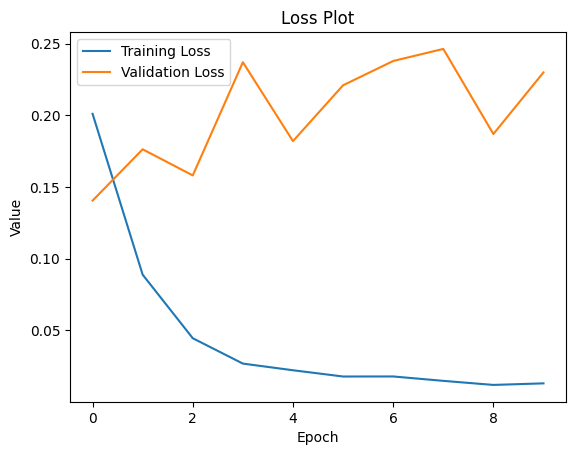

In [ ]:
plt.figure(1)
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.savefig(graph_path+ model_save_name + ' Train & Validation Loss.png',dpi=300,bbox_inches='tight')

## plot train & validation accuracy

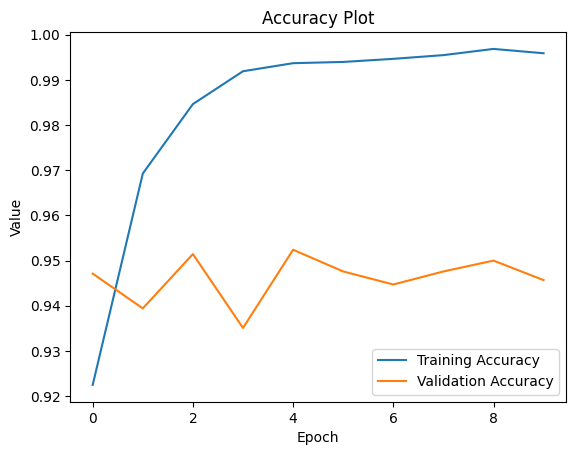

In [ ]:
plt.figure(2)
plt.plot(history['accuracy'], label='Training Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="best")
plt.savefig(graph_path+ model_save_name + ' Train & Validation Accuracy.png',dpi=300,bbox_inches='tight')

In [ ]:
history['accuracy']

[0.9224859377143642,
 0.9692687611469337,
 0.9846343805734669,
 0.9919056111949512,
 0.9936891205926739,
 0.993963506653862,
 0.9946494718068322,
 0.9954726299903965,
 0.996844560296337,
 0.9958842090821787]

In [ ]:
history['val_accuracy']

[0.9471153846153846,
 0.9394230769230769,
 0.9514423076923076,
 0.9350961538461539,
 0.9524038461538461,
 0.9475961538461538,
 0.9447115384615384,
 0.9475961538461538,
 0.95,
 0.9456730769230769]

In [ ]:
history['loss']

[0.20095814795339512,
 0.08871317213337884,
 0.04438137717538906,
 0.026686410559928493,
 0.02204034410788792,
 0.017671931915461563,
 0.017708041416322852,
 0.014639108629923788,
 0.011803958226249833,
 0.012895126758641646]

In [ ]:
history['val_loss']

[0.14040222255369791,
 0.1762034342552607,
 0.15798949071367344,
 0.23696357933893944,
 0.18190729366794514,
 0.22087801839090668,
 0.23782031265302347,
 0.24624483716123416,
 0.1868641463923268,
 0.22986621319029768]

## Evaluate on test

In [ ]:
test_loss, test_acc, test_auc_score, list_y_pred, list_y_prob, list_y_true = test(model, test_dataloader)

Test LOSS:0.2201  ACC:0.9433 : 100%|██████████| 66/66 [00:09<00:00,  6.84it/s]


Elapsed : 0:00:10


In [ ]:
list_y_prob

array([1.39852809e-05, 1.95241938e-07, 9.99999762e-01, ...,
       1.49304270e-07, 4.30303601e-07, 9.99999881e-01])

# Ukur

In [ ]:
cf_matrix = confusion_matrix(list_y_true, list_y_pred)
cf_matrix

array([[474,  46],
       [ 13, 508]])

<Figure size 640x480 with 0 Axes>

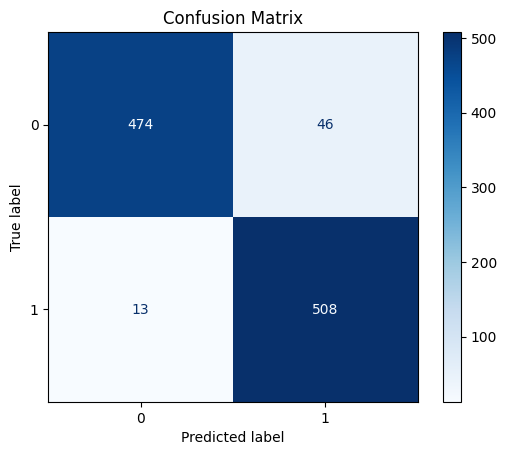

In [ ]:
plt.figure(3)
cf_matrix = ConfusionMatrixDisplay.from_predictions(list_y_true, list_y_pred, cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig(graph_path + model_identifier + model_save_name + ' Confusion Matrix.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
precision, recall, f1_score, support = precision_recall_fscore_support(list_y_pred, list_y_true)
mcc_score = matthews_corrcoef(list_y_true, list_y_pred)

print("Accuracy: %.4f" % test_acc)
print("AUC: %.4f" % test_auc_score)
print("MCC: %.4f" % mcc_score)
print("Loss: %.4f" % test_loss)
print("Precision: %.4f " % np.mean(precision))
print("Recall: %.4f " % np.mean(recall))
print("F1-Score: %.4f " % np.mean(f1_score))

Accuracy: 0.9433
AUC: 0.9891
MCC: 0.8884
Loss: 0.2201
Precision: 0.9433 
Recall: 0.9451 
F1-Score: 0.9433 


In [ ]:
test_report = {
    'test_accuracy': test_acc,
    'test_auc_score': test_auc_score,
    'test_mcc_score': mcc_score,
    'test_loss': test_loss,
    'test_precision': np.mean(precision),
    'test_recall': np.mean(recall),
    'test_f1_score': np.mean(f1_score)
    }

In [ ]:
df_report = pd.DataFrame(test_report, index=[0])

# Define the output file name
output_report_file = report_path + model_identifier + model_save_name + ' testing report.csv'

# Write the DataFrame to a CSV file
df_report.to_csv(output_report_file, index=False)

In [ ]:
# print the wrong predicted label

# Create a DataFrame to store the results
df = pd.DataFrame(columns=["Index", "Sentence", "True Label", "Predicted Label"])

i=0
for index, value in original_test_labels.iteritems():
  if value != list_y_pred[i]:
    true_label = value
    predicted_label = list_y_pred[i]
    sentence = text[index]
    df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
                       ignore_index=True)
    print('True Label:', true_label, '|', 'Predicted Label:', predicted_label)
    print('index:', index)
    print('Sentence:', sentence, '\n')
  i=i+1

# Define the output file name
output_report_file = report_path + model_identifier + model_save_name + ' wrong predictions report.csv'

# Write the DataFrame to a CSV file
df.to_csv(output_report_file, index=False)

<ipython-input-68-9af280cca4c4>:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in original_test_labels.iteritems():
<ipython-input-68-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-68-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-68-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True La

True Label: 0 | Predicted Label: 1
index: 8122
Sentence: tolong developer diperbaiki lagi bug nya kalau bisa dikasih unlimited money biar bisa isi minyak bbm sepuasnya tanpa bayar 

True Label: 0 | Predicted Label: 1
index: 6253
Sentence: email hilang enggak ada yang bisa bantu tanya sini enggak tao tanya sana enggak tao jadi mesti cari oles-oles kemana agar mudah di akses kami cuma mau bantu aplikasi ini kalo aplikasi bikin kepala kami selamat kami enggak bisa berbuat apa lagi tanpa kami aplikasi enggak akan jalan ujung tombak aplikasi itu kami tolong pertimbangkan sekalinya agar lebih mudah 

True Label: 1 | Predicted Label: 0
index: 7472
Sentence: tak kasih bintang dulu buat memotivasi supaya semakin bgu aplikasinya nanti kalau sudah bisa baru saya kasih bintang karena saya pakai selau gagal masukkan nomor tanya saya berharap semoga lebih di kembangkan lagi ayo semangat jangan keos demi keuntungan bersama 

True Label: 0 | Predicted Label: 1
index: 10160
Sentence: kepada admin tolon

<ipython-input-68-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-68-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-68-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-68-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

# Save and Load Model

## Save tokenizer

In [ ]:
tokenizer.save_pretrained(tokenizer_path)

## Save last model

In [ ]:
# save the trained model weights for a final time
save_model(epoch, model, optimizer, criterion)

Saving final model...


In [ ]:
import os.path

sz = os.path.getsize(model_path)
print(f'The {model_path} size is', sz, 'bytes')

## Load Best model

In [ ]:
# load the best model checkpoint
best_model_cp = torch.load(best_model_path)
best_model_epoch = best_model_cp['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")

Best model was saved at 5 epochs



In [ ]:
print(best_model_path)

/content/gdrive/My Drive/TA/Ards/saved/b_IBDmg_2e5_d2_16.pth


In [ ]:
del model

In [ ]:
model_identifier = "b_"

In [ ]:
model = IndoBERTBiLSTM(
              bert_config,
              bert,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT)

In [ ]:
model.load_state_dict(best_model_cp['model_state_dict'])
model.cuda()

IndoBERTBiLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

## Load last model

In [ ]:
# load the last model checkpoint
last_model_cp = torch.load(model_path)
last_model_epoch = last_model_cp['epoch']
print(f"Last model was saved at {last_model_epoch} epochs\n")

Last model was saved at 9 epochs



In [ ]:
model_identifier = "f_"

In [ ]:
model = IndoBERTBiLSTM(
              bert_config,
              bert,
              HIDDEN_DIM,
              OUTPUT_DIM,
              N_LAYERS,
              BIDIRECTIONAL,
              DROPOUT)

In [ ]:
model.load_state_dict(last_model_cp['model_state_dict'])
model.cuda()

IndoBERTBiLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

## Testing

In [ ]:
test(model, test_dataloader);

Test LOSS:0.1906  ACC:0.9568 : 100%|██████████| 33/33 [00:07<00:00,  4.28it/s]

Elapsed : 0:00:08


# New Section

## Evaluate on test

In [ ]:
test_loss, test_acc, test_auc_score, list_y_pred, list_y_prob, list_y_true = test(model, test_dataloader)

Test LOSS:0.1881  ACC:0.9549 : 100%|██████████| 66/66 [00:09<00:00,  6.71it/s]

Elapsed : 0:00:10


In [ ]:
list_y_prob

array([1.77112582e-07, 1.68012093e-07, 9.99999762e-01, ...,
       4.48382991e-07, 2.16317659e-07, 9.99999762e-01])

## Ukur

In [ ]:
cf_matrix = confusion_matrix(list_y_true, list_y_pred)
cf_matrix

array([[509,  11],
       [  4, 517]])

<Figure size 640x480 with 0 Axes>

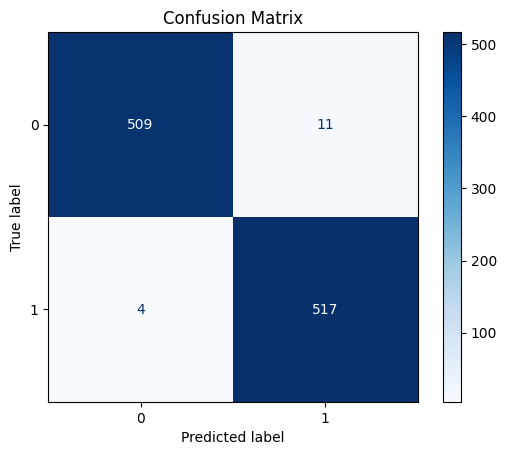

In [ ]:
plt.figure(3)
cf_matrix = ConfusionMatrixDisplay.from_predictions(list_y_true, list_y_pred, cmap='Blues')
plt.title('Confusion Matrix')
plt.savefig(graph_path + model_identifier + model_save_name + ' Confusion Matrix.png',dpi=300,bbox_inches='tight')
plt.show()

In [ ]:
precision, recall, f1_score, support = precision_recall_fscore_support(list_y_pred, list_y_true)
mcc_score = matthews_corrcoef(list_y_true, list_y_pred)

print("Accuracy: %.6f" % test_acc)
print("AUC: %.4f" % test_auc_score)
print("MCC: %.4f" % mcc_score)
print("Loss: %.4f" % test_loss)
print("Precision: %.4f " % np.mean(precision))
print("Recall: %.4f " % np.mean(recall))
print("F1-Score: %.4f " % np.mean(f1_score))

Accuracy: 0.985591
AUC: 0.9992
MCC: 0.9713
Loss: 0.0394
Precision: 0.9856 
Recall: 0.9857 
F1-Score: 0.9856 


In [ ]:
test_report = {
    'test_accuracy': test_acc,
    'test_auc_score': test_auc_score,
    'test_mcc_score': mcc_score,
    'test_loss': test_loss,
    'test_precision': np.mean(precision),
    'test_recall': np.mean(recall),
    'test_f1_score': np.mean(f1_score)
    }

In [ ]:
df_report = pd.DataFrame(test_report, index=[0])

# Define the output file name
output_report_file = report_path + model_identifier + model_save_name + ' testing report.csv'

# Write the DataFrame to a CSV file
df_report.to_csv(output_report_file, index=False)

In [ ]:
# print the wrong predicted label

# Create a DataFrame to store the results
df = pd.DataFrame(columns=["Index", "Sentence", "True Label", "Predicted Label"])

i=0
for index, value in original_test_labels.iteritems():
  if value != list_y_pred[i]:
    true_label = value
    predicted_label = list_y_pred[i]
    sentence = text[index]
    df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
                       ignore_index=True)
    print('True Label:', true_label, '|', 'Predicted Label:', predicted_label)
    print('index:', index)
    print('Sentence:', sentence, '\n')
  i=i+1

# Define the output file name
output_report_file = report_path + model_identifier + model_save_name + ' wrong predictions report.csv'

# Write the DataFrame to a CSV file
df.to_csv(output_report_file, index=False)

<ipython-input-64-9af280cca4c4>:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in original_test_labels.iteritems():
<ipython-input-64-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-64-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-64-9af280cca4c4>:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True La

True Label: 0 | Predicted Label: 1
index: 8122
Sentence: tolong developer diperbaiki lagi bug nya kalau bisa dikasih unlimited money biar bisa isi minyak bbm sepuasnya tanpa bayar 

True Label: 0 | Predicted Label: 1
index: 7294
Sentence: informasi yang di berikan cukup mudah cara membacanya dan untuk metode pembayarannya cukup mudah 

True Label: 0 | Predicted Label: 1
index: 2268
Sentence: sudah ok tapi masih ada kendala pada spbu yang kadang masih belum menerima pembayaran melalui aplikasi ini dengan alasan masih error 

True Label: 1 | Predicted Label: 0
index: 9467
Sentence: lemot enggak guna 

True Label: 0 | Predicted Label: 1
index: 6396
Sentence: saya kasih bintang dulu semoga di acc langsung baru nanti dikasih bintang setelah di acc semoga ini aplikasi yang tidak ribet dan mudah dalam pencairan ketika semua data kita sudah isi dengan baik dan benar terimakasih untuk perhatiannya 

True Label: 0 | Predicted Label: 1
index: 9068
Sentence: pokok enggak lemot waktu scan struk 

T

In [ ]:
# print the wrong predicted label

# Create a DataFrame to store the results
df = pd.DataFrame(columns=["Index", "Sentence", "True Label", "Predicted Label"])

i=0
for index, value in original_test_labels.iteritems():
  true_label = value
  predicted_label = list_y_pred[i]
  sentence = text[index]
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
                      ignore_index=True)
  # print('True Label:', true_label, '|', 'Predicted Label:', predicted_label)
  # print('index:', index)
  # print('Sentence:', sentence, '\n')
  i=i+1

print(i)
# Define the output file name
output_report_file = report_path + model_identifier + model_save_name + ' all test.csv'

# Write the DataFrame to a CSV file
df.to_csv(output_report_file, index=False)

<ipython-input-65-7534fcb2f2a3>:7: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, value in original_test_labels.iteritems():
<ipython-input-65-7534fcb2f2a3>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-65-7534fcb2f2a3>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-65-7534fcb2f2a3>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True La

1041


<ipython-input-65-7534fcb2f2a3>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-65-7534fcb2f2a3>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-65-7534fcb2f2a3>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Index": index, "Sentence": sentence, "True Label": true_label, "Predicted Label": predicted_label},
<ipython-input-65-7534fcb2f2a3>:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future ver

## Bests


In [ ]:
precision, recall, f1_score, support = precision_recall_fscore_support(list_y_pred, list_y_true)
mcc_score = matthews_corrcoef(list_y_true, list_y_pred)

print("Accuracy: %.4f" % test_acc)
print("AUC: %.4f" % test_auc_score)
print("MCC: %.4f" % mcc_score)
print("Loss: %.4f" % test_loss)
print("Precision: %.4f " % np.mean(precision))
print("Recall: %.4f " % np.mean(recall))
print("F1-Score: %.4f " % np.mean(f1_score))

Accuracy: 0.9587
AUC: 0.9914
MCC: 0.9174
Loss: 0.1692
Precision: 0.9587 
Recall: 0.9587 
F1-Score: 0.9587 


# Upload model

## Upload to hub

In [ ]:
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
model.push_to_hub("kadabengaran/IndoBERT-BiLSTM-Useful-App-Review")

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/602M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/kadabengaran/IndoBERT-BiLSTM-Useful-App-Review/commit/d846405e8f674d25fffd8e3fb36617f635532bfb', commit_message='Upload IndoBERTBiLSTM', commit_description='', oid='d846405e8f674d25fffd8e3fb36617f635532bfb', pr_url=None, pr_revision=None, pr_num=None)

In [ ]:
tokenizer.push_to_hub("kadabengaran/IndoBERT-BiLSTM-Useful-App-Review")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/_commit_api.py:232: UserWarning: About to update multiple times the same file in the same commit: 'vocab.txt'. This can cause undesired inconsistencies in your repo.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/_commit_api.py:232: UserWarning: About to update multiple times the same file in the same commit: 'tokenizer_config.json'. This can cause undesired inconsistencies in your repo.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/_commit_api.py:232: UserWarning: About to update multiple times the same file in the same commit: 'special_tokens_map.json'. This can cause undesired inconsistencies in your repo.
  warnings.warn(


CommitInfo(commit_url='https://huggingface.co/kadabengaran/IndoBERT-BiLSTM-Useful-App-Review/commit/680f300e4704ede7d63650daf727bd14199973d5', commit_message='Upload tokenizer', commit_description='', oid='680f300e4704ede7d63650daf727bd14199973d5', pr_url=None, pr_revision=None, pr_num=None)

## Load from hub

In [ ]:
del model

In [ ]:
MODEL = "kadabengaran/IndoBERT-BiLSTM-Useful-App-Review"

model = IndoBERTBiLSTM.from_pretrained(MODEL,
                                     bert,
                                     HIDDEN_DIM,
                                     OUTPUT_DIM,
                                     N_LAYERS, BIDIRECTIONAL,
                                     DROPOUT)
model.cuda()

IndoBERTBiLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

# Predict

In [ ]:
import re

def remove_special_characters(text):

    # case folding
    text = text.lower()

    # menghapus karakter khusus
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'[0-9]', ' ', text)

    # # replace multiple whitespace characters with a single space
    text = re.sub(r"\s+", " ", text)

    return text

In [ ]:
del tokenizer

In [ ]:
tokenizer_path = main_path + F"tokenizer/{model_name}"
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

In [ ]:
# input_text = "saya sudah terverivikasi dan sdh sempat SS barcode, bgtu bbrp bulan kemudian tidak sengaja terhapus barcode nya,ketika sy mau unduh lg masa hrs mulai dr awal lg . Mohon di perbaiki dan di permudah untuk login."
# input_text = "aplikasi terkutuk loginnya seperti menangkap koruptor susah setengah mati"
# input_text = "kesulitan mengisi minyak karena atm jauh dan tidak ada cash semoga dengan ini semua kendala teratasi"
input_text = "aplikasi sangat banyak bug dan malah menyusahkan pengguna sehingga bukannya memudahkan tapi malah menyebabkan antrian di spbu"
# input_text = "aduh aplikasi murahan mau dipakai rakyat kirim sms verifikasi saja nyangkut entah dimana jangan buang waktu pakai aplikasi murahan ini perbaiki dulu pakai modalnya dengan maksimal jangan di korupsi ya pak bikin aplikasi yang top"

In [ ]:
def predict(text, model, tokenizer, device):
    if device.type == 'cuda':
        model.cuda()

    test_ids = []
    test_attention_mask = []

    text = remove_special_characters(text)
    encoding = tokenize_data(text, tokenizer)

    # Extract IDs and Attention Mask
    test_ids.append(encoding['input_ids'])
    test_attention_mask.append(encoding['attention_mask'])
    test_ids = torch.cat(test_ids, dim=0)
    test_attention_mask = torch.cat(test_attention_mask, dim=0)

    # Forward pass, calculate logit
    with torch.no_grad():
        outputs = model(test_ids.to(device),
                        test_attention_mask.to(device))
    print("output ", outputs)
    predictions = torch.argmax(outputs, dim=-1)
    print("output ", predictions)
    return predictions.item()

In [ ]:
def get_key(val, my_dict):
    for key, value in my_dict.items():
        if val == value:
            return key

In [ ]:
prediction_labels = {'Not Useful': 0, 'Useful': 1}
prediction = predict(input_text, model, tokenizer, device)
final_result = get_key(prediction, prediction_labels)
final_result

output  tensor([[ 3.0563, -2.9960]], device='cuda:0')
output  tensor([0], device='cuda:0')


'Not Useful'

In [ ]:
final_result

'Not Useful'

# Predict Multi

In [ ]:
import re

def remove_special_characters(text):

    # case folding
    text = text.lower()

    # menghapus karakter khusus
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'[0-9]', ' ', text)

    # # replace multiple whitespace characters with a single space
    text = re.sub(r"\s+", " ", text)

    return text

 sangat suuusah diakses terlalu banyak persyaratan yg harus diisi saat sudah mengisi belum tentu terdaftar sangat menyusahkan masyarakat menghabiskan waktu aja sia buang buang waktu


In [ ]:
del tokenizer

In [ ]:
tokenizer_path = main_path + F"tokenizer/{model_name}"
tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

In [ ]:
data_multi = pd.read_csv(main_path + "datas/100 test new.csv", encoding='latin-1')

header_list = data_multi.columns.tolist()
header_list.insert(0, "---------- select column -------------")
header_list

['---------- select column -------------',
 'ï»¿label',
 'userName',
 'score',
 'at',
 'content']

In [ ]:
index = 5

In [ ]:
data_multi[header_list[index]]

0     app mypertamina di hp saya tidak bisa lagi log...
1                          tidak bisa akses qr code nya
2        mau masuk barcode saja tidak bisa piye to kih 
3     setelah update malah menu program subsidi tepa...
4     aplikasi sangat aneh tidak bisa terhubung deng...
                            ...                        
95    sangat payah digunakan ber ulang ulang daftar ...
96           pendaftaran sangat susah lagi ke menu awal
97    itu lah makin susah ngisi bbm mana harga makin...
98    susah iya melawan orang pintar otak otak nya m...
99    saya doakan pertamina bangkrut spbu nya kebaka...
Name: content, Length: 100, dtype: object

In [ ]:
df_process = data_multi[header_list[index]]
csv_input = data_multi
csv_process = df_process

In [ ]:
def predict_multiple(data, model, tokenizer, device):
    input_ids = []
    attention_masks = []
    print("Preprocess.....")
    for row in tqdm(data.tolist()):
        text = remove_special_characters(row)
        text = tokenize_data(text, tokenizer)
        input_ids.append(text['input_ids'])
        attention_masks.append(text['attention_mask'])

    predictions = []

    print("Classifying.....")
    with torch.no_grad():
        for i in tqdm(range(len(input_ids))):
            test_ids = input_ids[i]
            test_attention_mask = attention_masks[i]
            outputs = model(test_ids.to(device), test_attention_mask.to(device))
            prediction = torch.argmax(outputs, dim= -1)
            # prediction_label = get_key(prediction.item(), LABELS)
            predictions.append(prediction.item())

    return predictions

In [ ]:
prediction = predict_multiple(df_process, model, tokenizer, device)

Preprocess.....


  0%|          | 0/100 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 100/100 [00:00<00:00, 501.03it/s]


Classifying.....


100%|██████████| 100/100 [00:03<00:00, 33.00it/s]


In [ ]:
input_file = csv_input
input_file["classification_result"] = prediction
input_file.head(10)

,ï»¿label,userName,score,at,content,classification_result
0,1,Mangatas Simorangkir,3,11/21/2022 12:08,app mypertamina di hp saya tidak bisa lagi log...,1
1,1,Lukman Kurniawan,1,11/21/2022 11:39,tidak bisa akses qr code nya,1
2,1,Susanto Ganesa,1,11/21/2022 11:03,mau masuk barcode saja tidak bisa piye to kih,1
3,1,Tiyo Aldo,1,11/21/2022 10:27,setelah update malah menu program subsidi tepa...,1
4,1,majid irwanto,1,11/21/2022 9:05,aplikasi sangat aneh tidak bisa terhubung deng...,1
5,1,lucky jalu,1,11/21/2022 5:13,payah menu daftar transaksi tidak bisa dibuka,1
6,1,HERMAWAN KRISTI,1,11/21/2022 4:54,balik versi masih muncul qr barcode nya yang t...,1
7,1,Rey Lando,1,11/20/2022 15:06,ini sudah bulan tidak terverifikasi data saya ...,1
8,0,Muhammad Abdullah Ar-Rasyid,1,11/20/2022 12:44,maaf tinggal aplikasi enggak guna ditolak teru...,0
9,1,Stevanus Santoso,3,11/20/2022 12:01,susahnya untuk terhubung ke link aja tidak sep...,1


In [ ]:
# Define the output file name
output_classification_result_file = main_path + "datas/100 test new_predict.csv"

# Write the DataFrame to a CSV file
input_file.to_csv(output_classification_result_file, index=False)